# 6.6 Sourcing & Analyzing Time-Series Data

# Table of Contents
#### 1. Importing libraries & data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the GDP per Capita of Europe data

# 1. Importing libraries & data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'cs-3grDVERcQXtp-7QLf'

In [3]:
# Importing the OECD GDP per Capita of Europe
data = quandl.get('OECD/MEI_CLI_LORSGPNO_OECDE_M')

### https://data.nasdaq.com/data/OECD/MEI_CLI_LORSGPNO_OECDE_M-normalised-gdp-oecd-europe

### I chose to analyze the change in GDP per capita of Europe as most of the boats included in my dataset are located in Europe, and it is a safe assumption that economic conditions significantly impact the buying and selling of boats.

In [4]:
data.head()

,Value
Date,
1960-02-29,99.89750
1960-03-31,99.92860
1960-04-30,99.95197
1960-05-31,99.97649
1960-06-30,100.00760


In [5]:
data.shape

(751, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

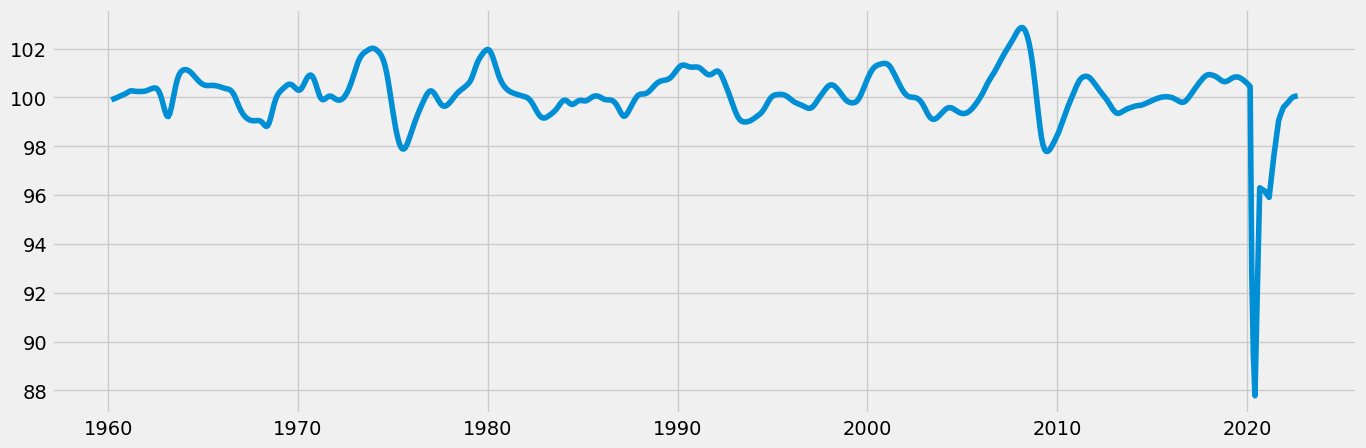

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1960-02-29,99.89750
1,1960-03-31,99.92860
2,1960-04-30,99.95197
3,1960-05-31,99.97649
4,1960-06-30,100.00760


In [11]:
data_2.shape

(751, 2)

In [12]:
data_sub=data_2

In [13]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1960-02-29,99.89750
1960-03-31,99.92860
1960-04-30,99.95197
1960-05-31,99.97649
1960-06-30,100.00760


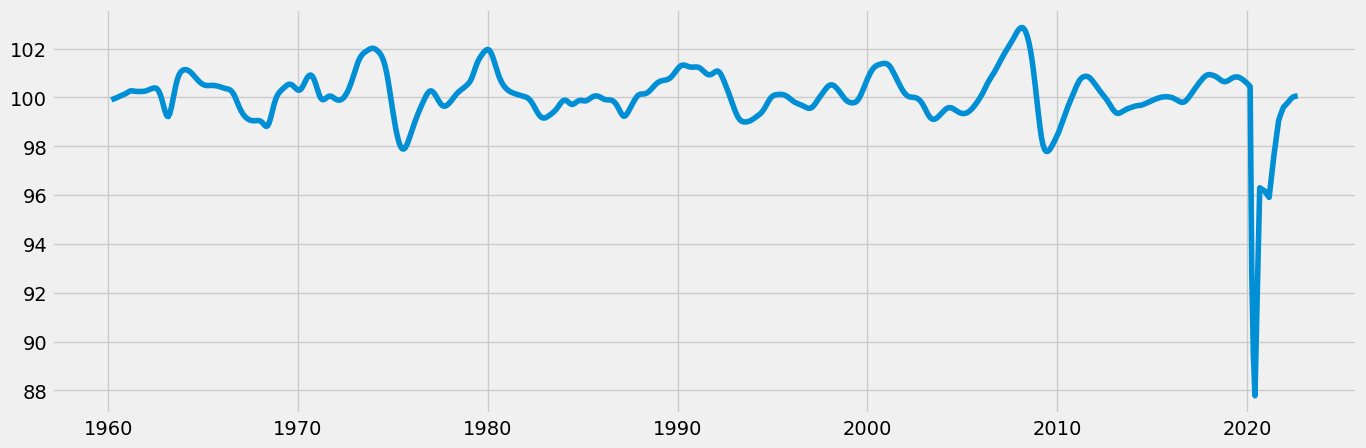

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [16]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

6

In [17]:
data_sub.head()

,Value
datetime,
1960-02-29,99.89750
1960-03-31,99.92860
1960-04-30,99.95197
1960-05-31,99.97649
1960-06-30,100.00760


# 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

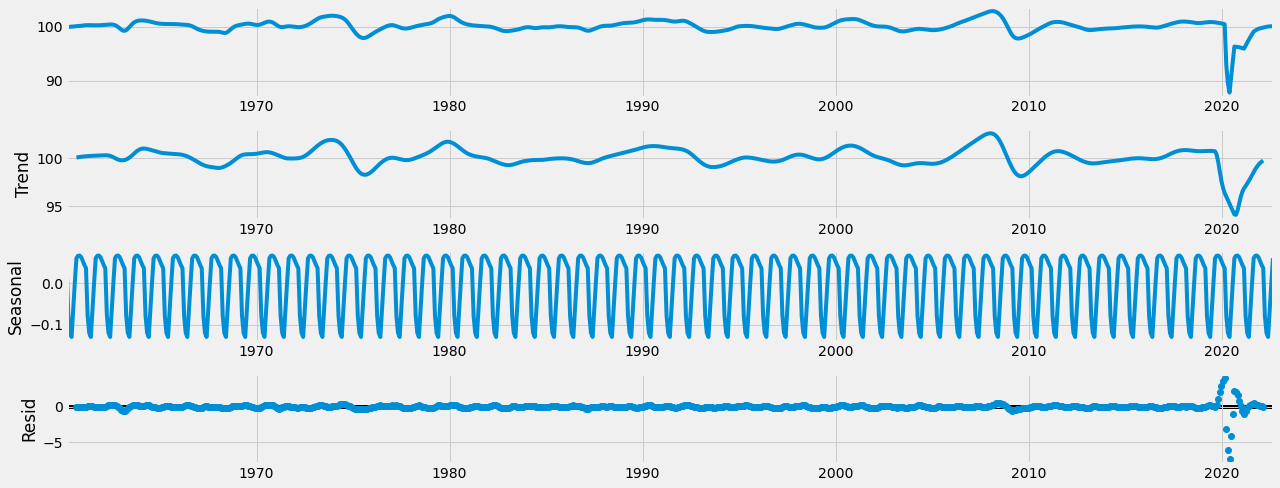

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

### There is not much of a trend over the years, however there are a few periods of larger fluctation. It can be seen that in both the mid 1970s and late 2000s that there was a quick period of growth followed by a steep decline. This spikes can be attributed to the global financial crisis that occurred at those times. The most significant fluctuation in the GDP per capita occurred due to COVID, which caused a drop twice that of either recession. 

### There is a clear pattern of seasonality in the dataset, in which the GDP per capita decreases every winter. This is due to the effects of the harsher weather and holiday season.

### The residual 'noise' appear very insignificant up until 2020, when COVID had severe effect on the GDP per capita.

# 4. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -6.350251e+00
p-value                        2.621618e-08
Number of Lags Used            9.000000e+00
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


### Since the test statistic is lower than the critical value at all significance levels, the null hypothesis can be rejected. This indicates that there is no unit root in the data, and it is stationary, allowing for forecasting to proceed.

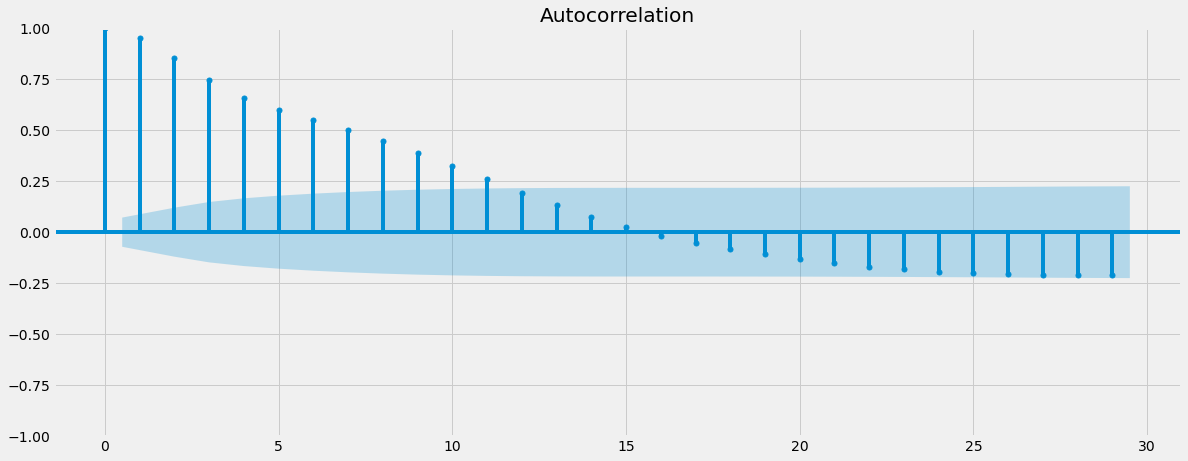

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### Although the Dickey-Fuller test proved the dataset was stationary, it can be seen by the 11 lags reaching beyond the edge of the confidence interval that it could be improved by differencing.

# 5. Stationarizing the GDP per Capita of Europe data

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
datetime,
1960-03-31,0.03110
1960-04-30,0.02337
1960-05-31,0.02452
1960-06-30,0.03111
1960-07-31,0.03430


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

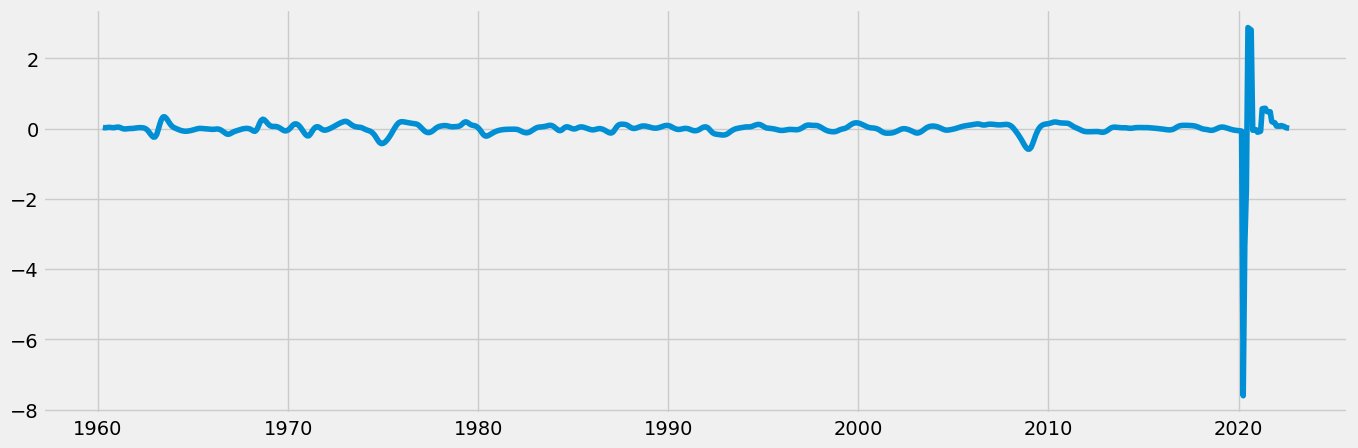

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.701281e+00
p-value                        3.803302e-14
Number of Lags Used            9.000000e+00
Number of Observations Used    7.400000e+02
Critical Value (1%)           -3.439218e+00
Critical Value (5%)           -2.865454e+00
Critical Value (10%)          -2.568854e+00
dtype: float64


### The test statistic is now even lower than the 3 critical values.

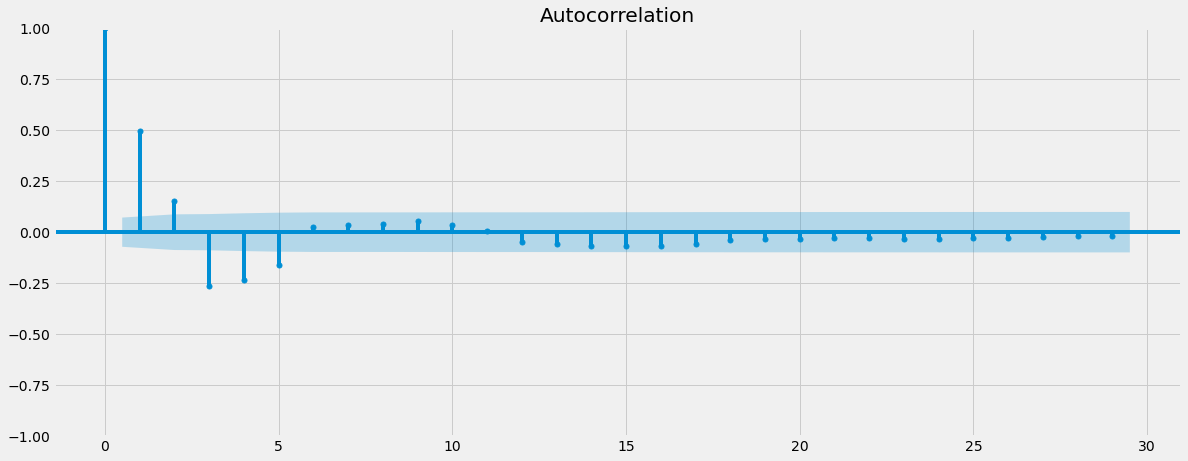

In [29]:
plot_acf(data_diff)
plt.show()

### The autocorrelation chart now shows only 6 total lags reaching outside of the confidence interval, a significant improvement to the stationarity of the data. 